## Needed packages

In [58]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import chi2
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

from radardetseval.visualization.plot_polyline import plot_polyline, plot_polyline_range_rates
from radardetseval.visualization.plot_sensor import plot_sensor
from radardetseval.visualization.plot_point import plot_point
from radardetseval.visualization.plot_detection import plot_detection_scs
from radardetseval.visualization.utilities import publish_reduced_labels
from radardetseval.utilities.ecdf import ecdf
from radardetseval.utilities.cart_state_to_polar_state import cart_state_to_polar_state


## Load data

In [59]:
data_path = r'private\sim_arc_90_degree_vel_4.0_n50000.pickle'
with open(data_path, 'rb') as handle:
    data = pickle.load(handle)

## Ground truth data summary

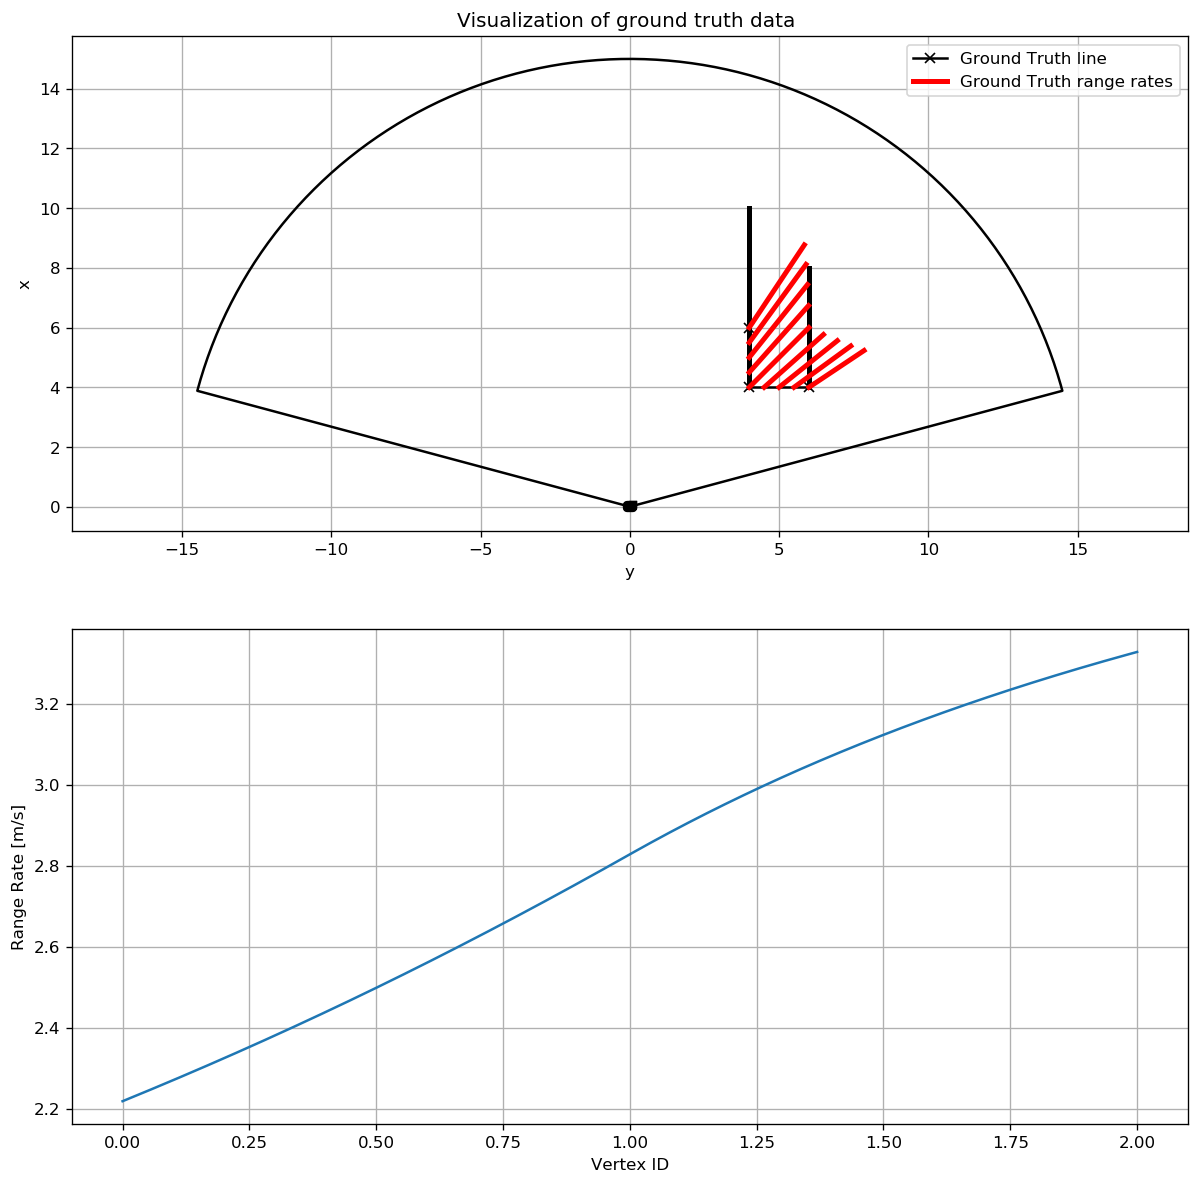

In [60]:
def plot_summary(ax, gt_polyline, title_str):
    plot_sensor(ax, azimuth=np.deg2rad(75.0), max_range=15.0)
    plot_polyline(ax, gt_polyline, color='k', label = 'Ground Truth line')
        
    gt_polyline.signals = gt_polyline.discretize_single_polygon(gt_polyline.signals, 0.5)
    plot_polyline_range_rates(ax, gt_polyline, label = 'Ground Truth range rates')
    
    ax.set_title(title_str)
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    publish_reduced_labels(ax)
    ax.axis('equal')
    ax.grid()

    
def plot_rr(ax, gt_polyline):
    vertex_ids = gt_polyline.signals['vertex_id'].values
    vertex_ids_discirte = np.linspace(vertex_ids.min(), vertex_ids.max(), 1000)
    discirte_df = gt_polyline.interpolate_polygon(vertex_ids_discirte, vertex_ids, gt_polyline.signals)
    ref_range, ref_azimuth, ref_range_rate, _ = cart_state_to_polar_state(discirte_df['x'],
                                                                          discirte_df['y'],
                                                                          discirte_df['vx'],
                                                                          discirte_df['vy'])
    ax.plot(vertex_ids_discirte, ref_range_rate) 
    ax.set_xlabel('Vertex ID')
    ax.set_ylabel('Range Rate [m/s]')
    ax.grid()
    
fig1=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
title_prefix = 'Visualization of ground truth data '

ax1 = plt.subplot(2, 1, 1)
plot_summary(ax1, deepcopy(data['gt_polyline']), title_prefix + '')

ax2 = plt.subplot(2, 1, 2)
plot_rr(ax2, deepcopy(data['gt_polyline']))


## Data examples

In [61]:
sim_out = deepcopy(data['sim_out'])
valid_df = sim_out.iloc[0:5]
valid_df

,unique_id,vertex_id,x,y,vx,vy,range,azimuth,range_rate,nees_value,gt_vertex_id
0,0.0,0.196296,4.020938,5.468377,4.010929,-0.011994,6.787568,0.936765,2.366401,1.367726,0.260612
1,0.0,0.444049,4.105516,5.066433,4.014674,-0.008486,6.521043,0.889784,2.520964,1.114352,0.501839
2,0.0,0.733819,3.812100,4.584234,4.005331,0.015550,5.962157,0.877101,2.572896,1.099168,0.650295
3,0.0,1.784557,5.587026,4.134744,4.002217,-0.000811,6.950610,0.637110,3.216572,4.494084,1.816464
4,0.0,1.769637,5.605297,4.018943,4.000376,-0.000511,6.897192,0.622038,3.250778,0.562952,1.753496


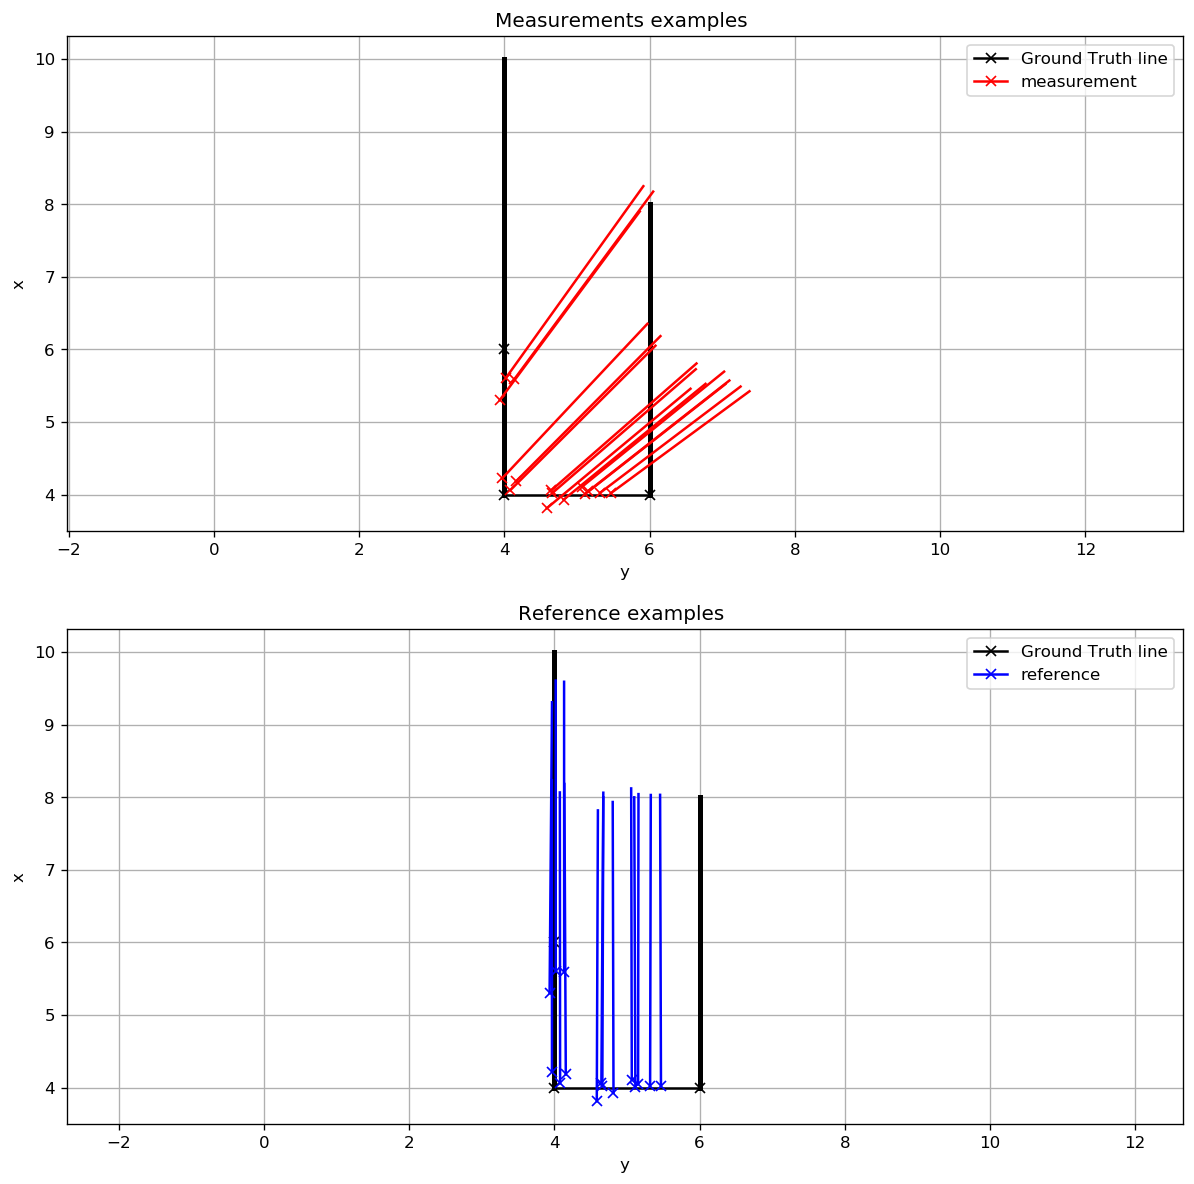

In [62]:
def plot_measurement_examples(ax, gt_polyline, sim_out, n_samples, title_str):
    plot_polyline(ax, gt_polyline, color='k', label = 'Ground Truth line')
    
    valid_df = sim_out.iloc[0:n_samples]
    for _, row in valid_df.iterrows():
        plot_detection_scs(ax, row.range, row.range_rate, row.azimuth, color='r', label='measurement')
    
    ax.set_title(title_str)
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    publish_reduced_labels(ax)
    ax.axis('equal')
    ax.grid()
    
def plot_reference_examples(ax, gt_polyline, sim_out, n_samples, title_str):
    plot_polyline(ax, gt_polyline, color='k', label = 'Ground Truth line')
    
    valid_df = sim_out.iloc[0:n_samples]
    for _, row in valid_df.iterrows():
        plot_point(ax, row.x, row.y, row.vx, row.vy, color='b', label='reference')
    
    ax.set_title(title_str)
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    publish_reduced_labels(ax)
    ax.axis('equal')
    ax.grid()
    

title_prefix_meas = 'Measurements examples '
title_prefix_ref= 'Reference examples '

n_samples = 15

fig2=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2, 1, 1)
plot_measurement_examples(ax1, deepcopy(data['gt_polyline']), deepcopy(data['sim_out']),
                          n_samples, title_prefix_meas)

ax2 = plt.subplot(2, 1, 2)
plot_reference_examples(ax2, deepcopy(data['gt_polyline']), deepcopy(data['sim_out']),
                        n_samples, title_prefix_ref)
    

## NEES distributions analysis

In [63]:
def visualize_distributions(df):
    chi2_dof = [2.0, 2.5, 3.0]  # 3 variables so 3 degree of freedom
    x_ref = np.linspace(0, 20, 1000)
    n_bins = 100

    plt.subplot(3, 1, 1)
    for dof in chi2_dof:
        y_ref = chi2.pdf(x_ref, dof)
        plt.plot(x_ref, y_ref, label=f'Chi-square with k = {dof:.1f}')
    df['nees_value'].hist(bins=n_bins, density=True, label='NEES from sim')
    plt.ylabel('Density [-]')
    plt.title('NEES distribution of simulated detection')
    plt.legend()

    plt.subplot(3, 1, 2)
    x_ecdf, y_ecdf = ecdf(df['nees_value'])

    for dof in chi2_dof:
        y_ref_cdf = chi2.cdf(x_ref, dof)
        plt.plot(x_ref, y_ref_cdf, label=f'Chi-square with k = {dof:.1f}')
    plt.plot(x_ecdf, y_ecdf, label='NEES from sim')
    plt.ylabel('Quantile [-]')
    plt.title('NEES cumulative distribution of simulated detection')
    plt.grid()
    plt.legend()

    plt.subplot(3, 1, 3)
    for dof in chi2_dof:
        y_ref_ecdf = chi2.cdf(x_ecdf, dof)
        ecdf_diff = y_ecdf - y_ref_ecdf
        plt.plot(x_ecdf, ecdf_diff, label=f'Chi-square with k = {dof:.1f}')
    plt.xlabel('NEES value [-]')
    plt.ylabel('CDF difference [-]')
    plt.grid()
    plt.legend()
    plt.xlim([0, 20])
    plt.title('Difference between empirical and reference cumulative distribution')


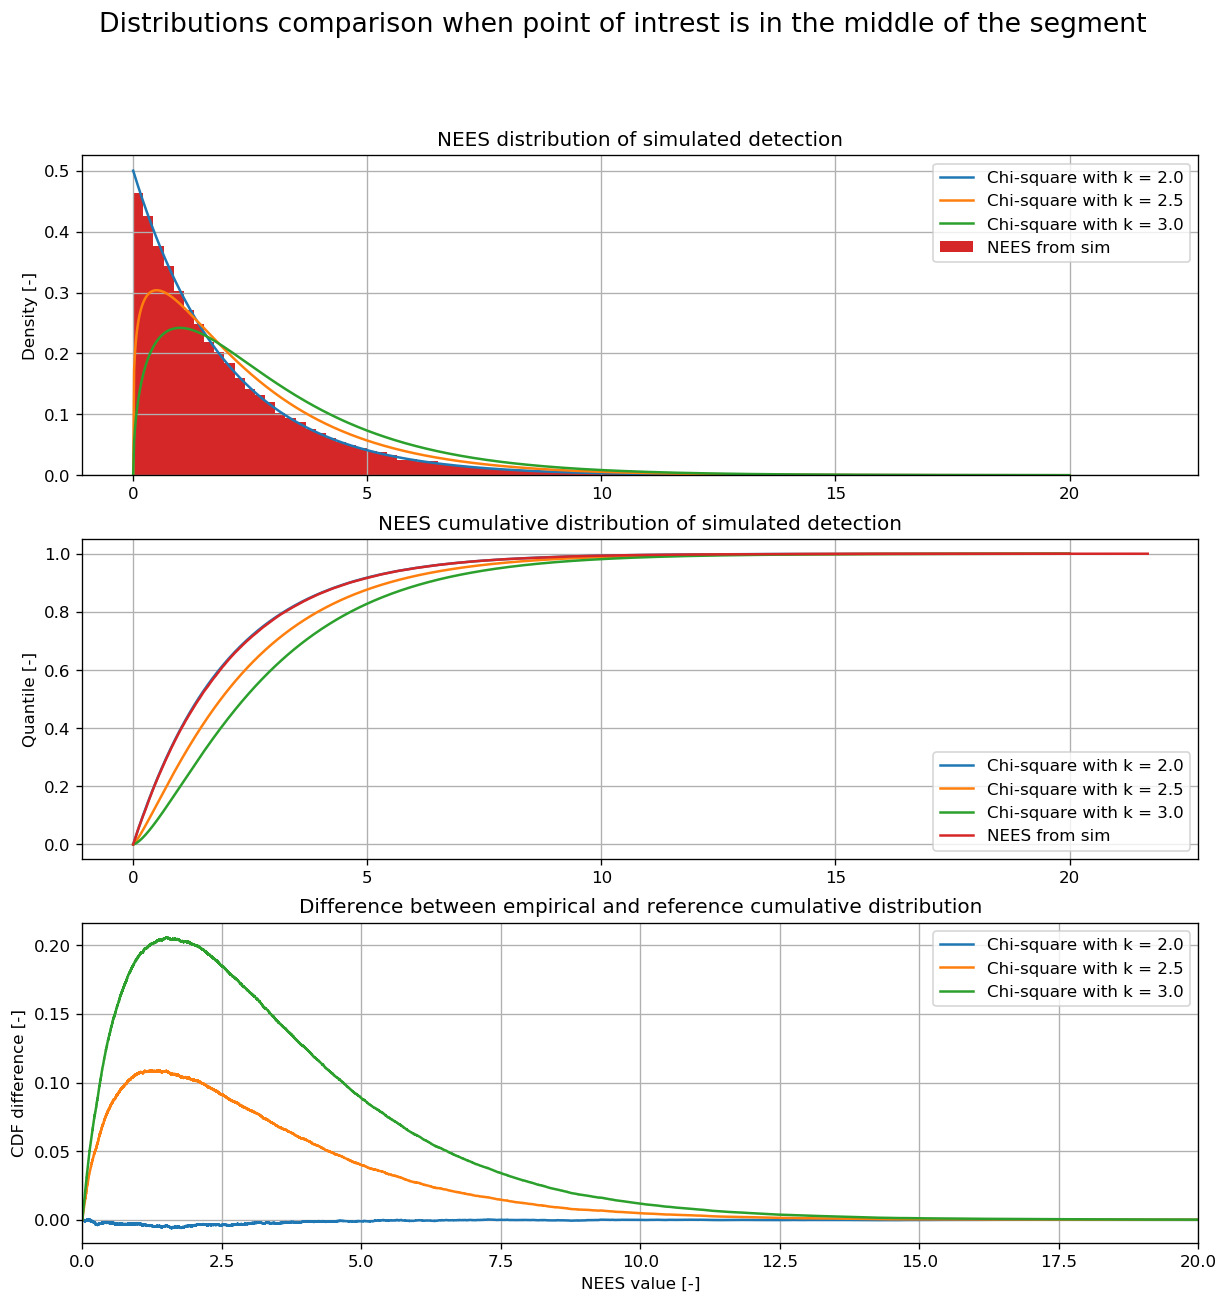

In [64]:
fig3=plt.figure(figsize=(12, 12), dpi= 120, facecolor='w', edgecolor='k')
fig3.suptitle('Distributions comparison when point of intrest is in the middle of the segment', fontsize=16)
visualize_distributions(deepcopy(data['sim_out']))

## Analyze in reference of vertex id 

Check an impact of location of detection within segment. Data will be split based on vertex id and there are two ptions how to do that:

* Based on Grount Truth vertex ID
* Beased on Vertex ID given by optimization procedure

Since Ground Truth vertex ID was uniformly drawned we can expect that number of samples for specific bin will will be similar. We can also expect change in mean of nees value from middle of segment to the edge of the segment from 2.0 to 2.5. 
However, in real wordl data the groud truth vertex ID is unknwon. The only known information is vertex id found in optimization process. So NEES mean value dependency needs to be analyzed having this data to decide which threshold should be used.

In [65]:
nbins = 200
bins = np.linspace(0,2,nbins)
sim_out = deepcopy(data['sim_out'])
sim_out_bins_est = sim_out.groupby(pd.cut(sim_out.vertex_id, bins))
sim_out_bins_gt = sim_out.groupby(pd.cut(sim_out.gt_vertex_id, bins))


In [66]:
def aggregate_nees_data(grouped_df):  
    df = pd.DataFrame([grouped_df['nees_value'].mean(), grouped_df['nees_value'].count()]).T
    df.columns = ['mean NEES', 'count']
    df['vertex_id'] = bins[0:-1] + 1/nbins/2
    
    def mean_conf_interval(samples, alpha=0.05):
        value = bs.bootstrap(samples.values, stat_func=bs_stats.mean, alpha=alpha)
        return value.lower_bound, value.upper_bound 
    
    intervals = grouped_df['nees_value'].aggregate(mean_conf_interval)
    intervals_np = np.array([*intervals.values])
    df['lower_bound'] = intervals_np[:,0]
    df['upper_bound'] = intervals_np[:,1]
    
    return df   
    

In [67]:
nees_data_est = aggregate_nees_data(sim_out_bins_est)
nees_data_gt = aggregate_nees_data(sim_out_bins_gt)

c:\users\lz7c3c\wkspaces\aspe0000_00_common\sandbox\radardetectionsevaluation\.venv_pe\lib\site-packages\numpy\matrixlib\defmatrix.py:447: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
c:\users\lz7c3c\wkspaces\aspe0000_00_common\sandbox\radardetectionsevaluation\.venv_pe\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


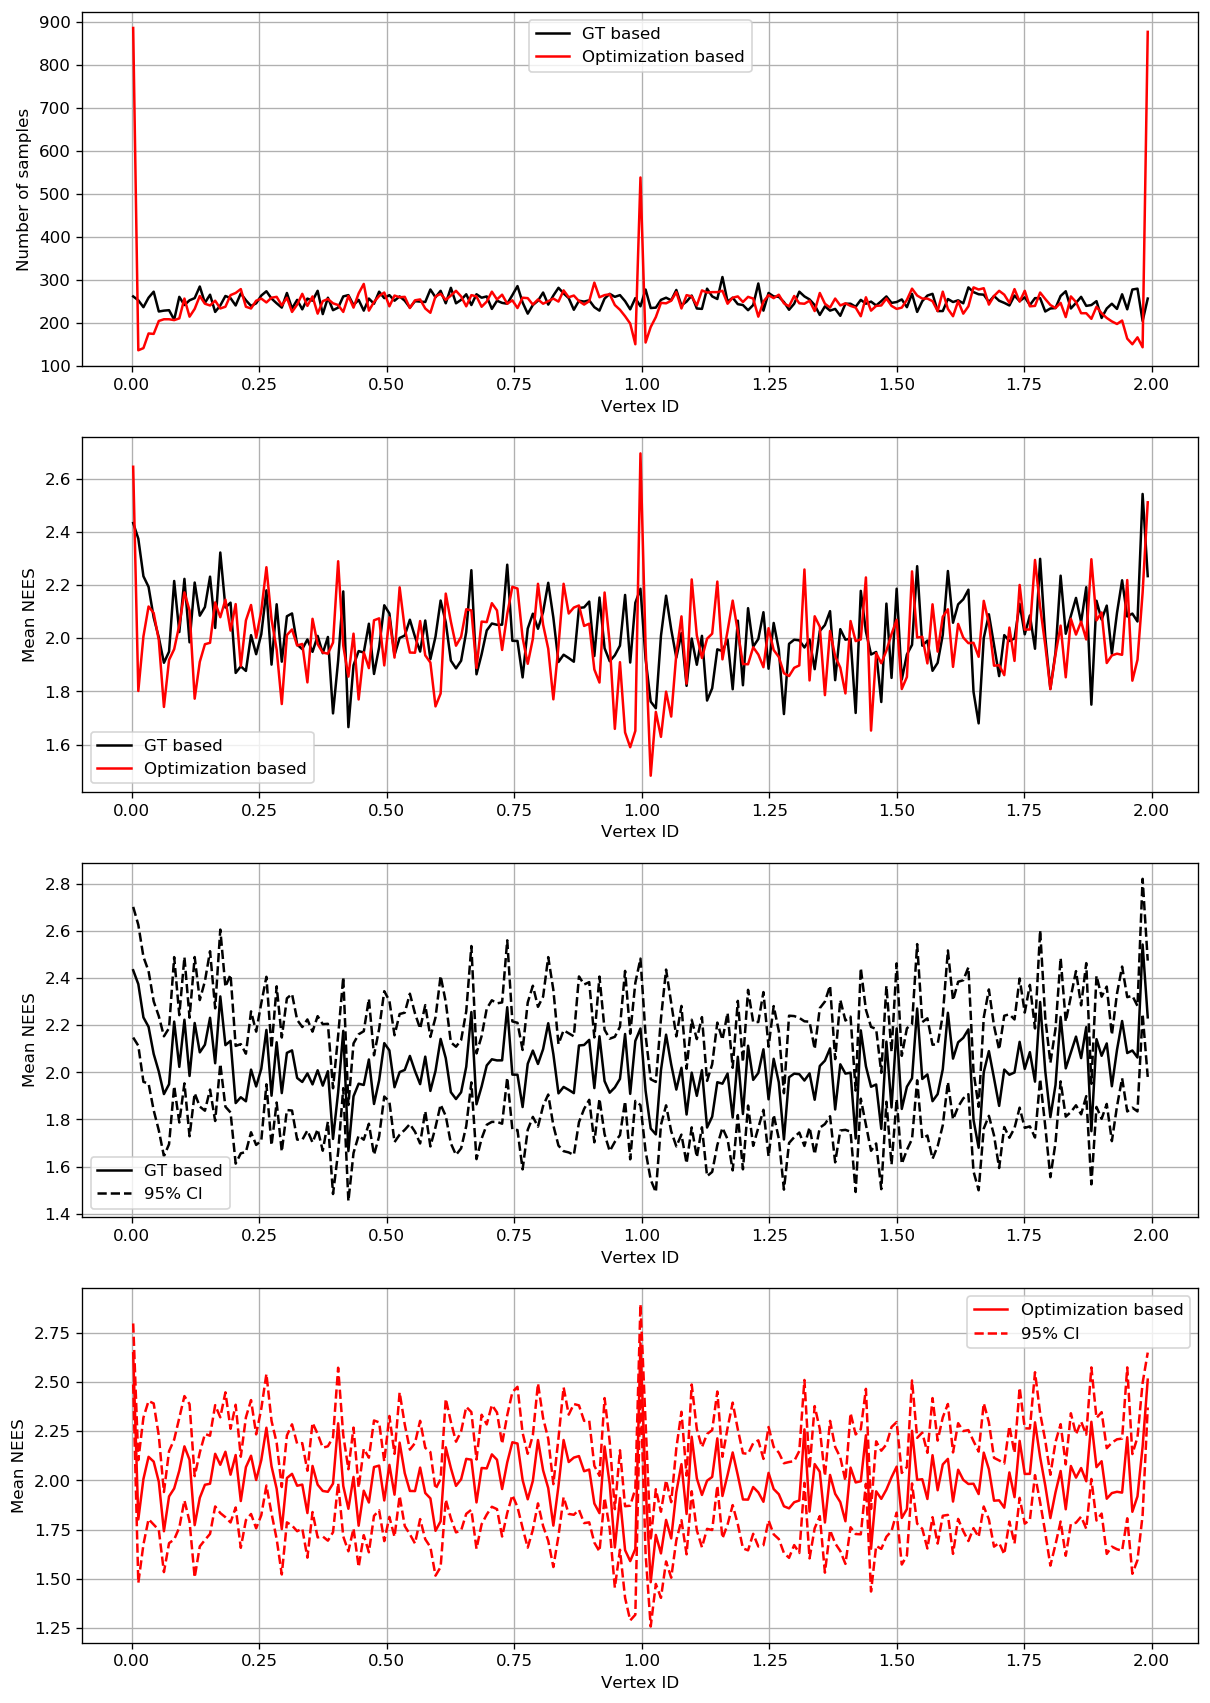

In [68]:
fig3=plt.figure(figsize=(12, 18), dpi= 120, facecolor='w', edgecolor='k')
ax1 = plt.subplot(4, 1, 1)
ax1.plot(nees_data_gt['vertex_id'], nees_data_gt['count'], 'k', label = 'GT based')
ax1.plot(nees_data_est['vertex_id'], nees_data_est['count'], 'r', label = 'Optimization based')
publish_reduced_labels(ax1)
ax1.set_xlabel('Vertex ID')
ax1.set_ylabel('Number of samples')
ax1.grid()

ax2 = plt.subplot(4, 1, 2)
ax2.plot(nees_data_gt['vertex_id'], nees_data_gt['mean NEES'], 'k', label = 'GT based')
ax2.plot(nees_data_est['vertex_id'], nees_data_est['mean NEES'], 'r', label = 'Optimization based')
publish_reduced_labels(ax2)
ax2.set_xlabel('Vertex ID')
ax2.set_ylabel('Mean NEES')
ax2.grid()

ax3 = plt.subplot(4, 1, 3)
ax3.plot(nees_data_gt['vertex_id'], nees_data_gt['mean NEES'], 'k', label = 'GT based')
ax3.plot(nees_data_gt['vertex_id'], nees_data_gt['lower_bound'], 'k', linestyle='dashed', label = '95% CI')
ax3.plot(nees_data_gt['vertex_id'], nees_data_gt['upper_bound'], 'k', linestyle='dashed', label = '95% CI')
publish_reduced_labels(ax3)
ax3.set_xlabel('Vertex ID')
ax3.set_ylabel('Mean NEES')
ax3.grid()

ax4 = plt.subplot(4, 1, 4)
ax4.plot(nees_data_est['vertex_id'], nees_data_est['mean NEES'], 'r', label = 'Optimization based')
ax4.plot(nees_data_est['vertex_id'], nees_data_est['lower_bound'], 'r', linestyle='dashed', label = '95% CI')
ax4.plot(nees_data_est['vertex_id'], nees_data_est['upper_bound'], 'r', linestyle='dashed', label = '95% CI')
publish_reduced_labels(ax4)
ax4.set_ylabel('Mean NEES')
ax4.set_xlabel('Vertex ID')
ax4.grid()

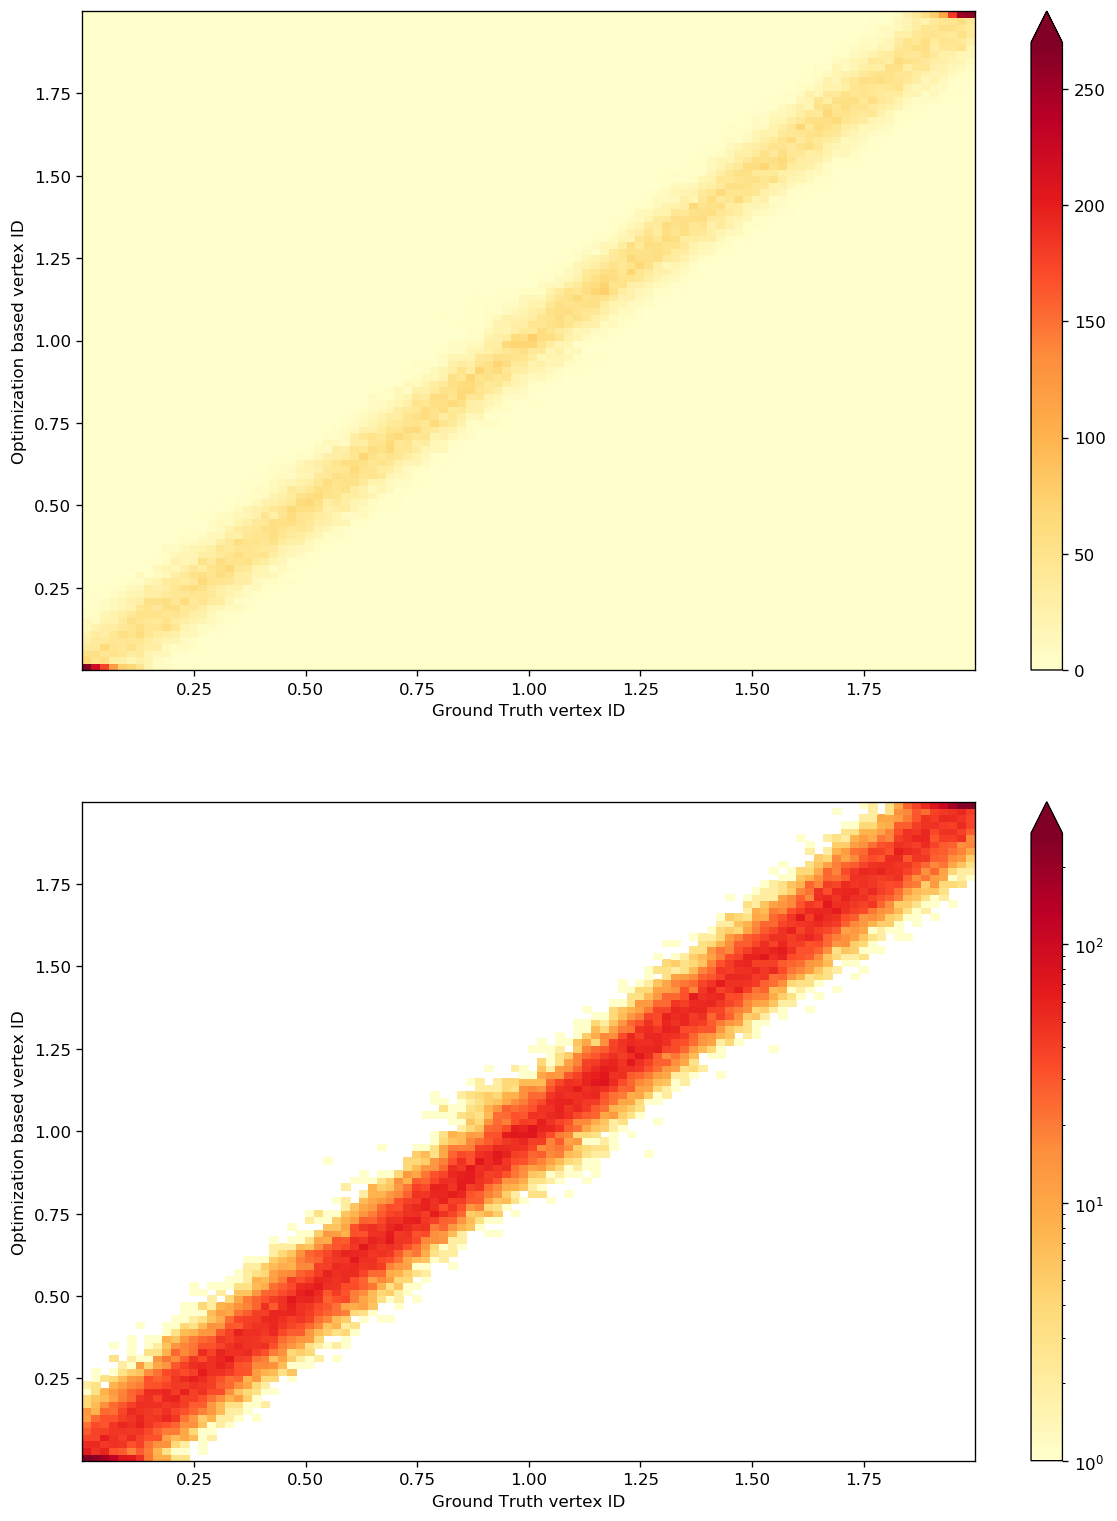

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(12, 16), dpi= 120, facecolor='w', edgecolor='k')

hist_out  = ax[0].hist2d(sim_out.gt_vertex_id, sim_out.vertex_id, bins=100,
                   cmap='YlOrRd')
ax[0].set_xlabel('Ground Truth vertex ID')
ax[0].set_ylabel('Optimization based vertex ID')
fig.colorbar(hist_out[3], ax=ax[0], extend='max')

hist_out = ax[1].hist2d(sim_out.gt_vertex_id, sim_out.vertex_id, bins=100,
                   norm=mcolors.LogNorm(),
                   cmap='YlOrRd')
ax[1].set_xlabel('Ground Truth vertex ID')
ax[1].set_ylabel('Optimization based vertex ID')
fig.colorbar(hist_out[3], ax=ax[1], extend='max')

## Analysis of different subsets

In [70]:
### Basic check when to put cut off points

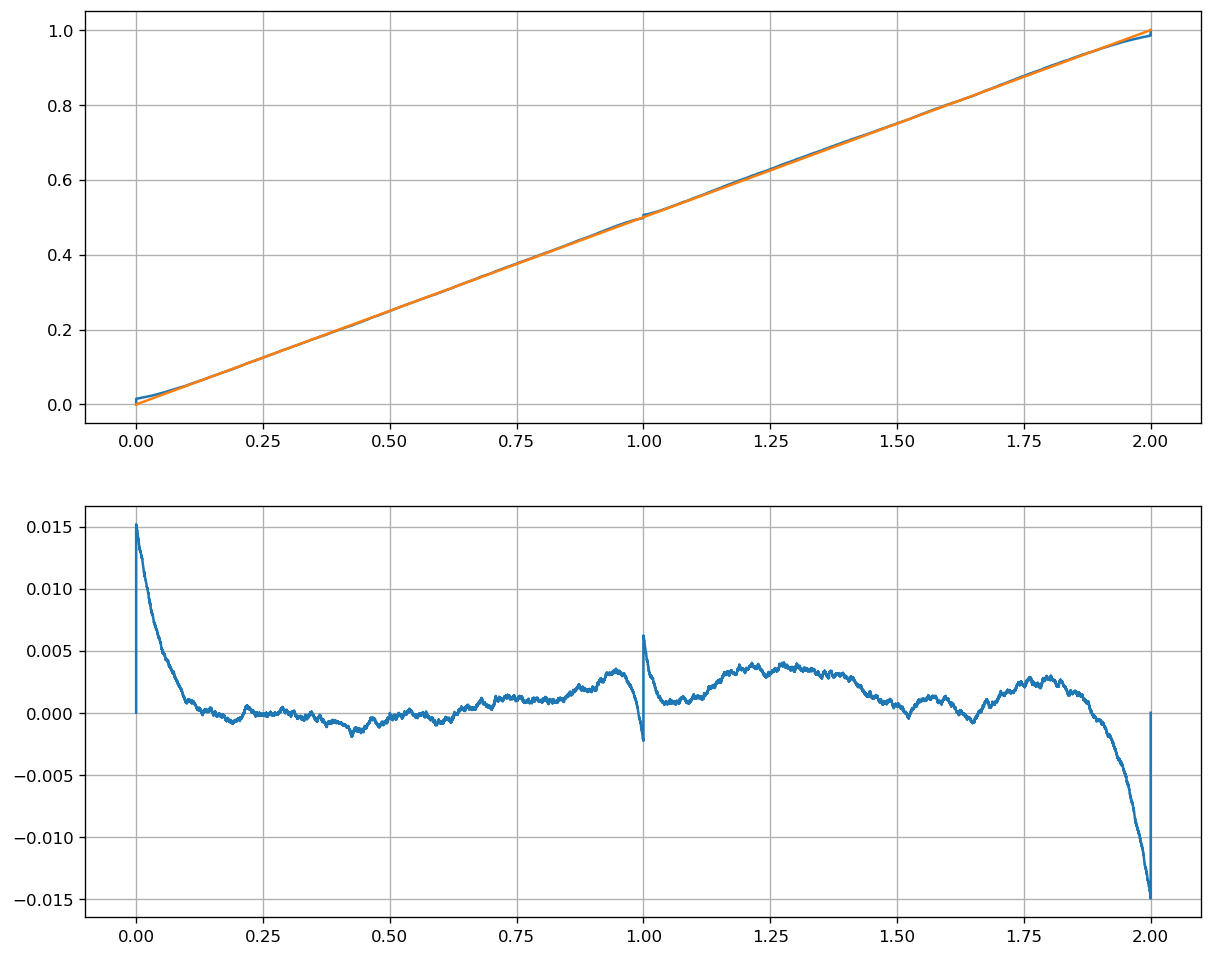

In [71]:
fig3=plt.figure(figsize=(12, 10), dpi= 120, facecolor='w', edgecolor='k')
x_ecdf, y_ecdf = ecdf(sim_out.vertex_id)

plt.subplot(2,1,1)
plt.plot(x_ecdf, y_ecdf)
plt.plot(x_ecdf, x_ecdf/2)
plt.grid()

plt.subplot(2,1,2)
plt.plot(x_ecdf, y_ecdf - x_ecdf/2)
plt.grid()

In [72]:
def visualize_distributions(grouped_data):
    chi2_dof = [2.0, 2.5]  # 3 variables so 3 degree of freedom
    xmax = 20
    alpha = 0.05
    x_ref = np.linspace(0, xmax, 1000)
   
    plt.subplot(4, 1, 1)
    coundts = grouped_data['nees_value'].count()
    x_ticks = grouped_data.groups
    x_values = np.arange(len(x_ticks))

    plt.bar(x_values, list(coundts.values))
    plt.xticks(x_values, x_ticks) 
    plt.title('Number of samples for different groups')
    plt.ylabel('Number of samples')
    plt.grid()    
    
    plt.subplot(4, 1, 2)
    for name, group in grouped_data:
        x_ecdf, y_ecdf = ecdf(group['nees_value'])
        plt.plot(x_ecdf, y_ecdf, label=name)
        
    for dof in chi2_dof:
        y_ref_cdf = chi2.cdf(x_ref, dof)
        plt.plot(x_ref, y_ref_cdf, label=f'Chi-square with k = {dof:.1f}')
    plt.ylabel('Quantile [-]')
    plt.title('NEES cumulative distribution of simulated detection')
    plt.grid()
    plt.legend()
    
    plt.subplot(4, 1, 3)
    k = chi2_dof[0]
    for name, group in grouped_data:
        x_ecdf, y_ecdf = ecdf(group['nees_value'])
        y_ref_ecdf = chi2.cdf(x_ecdf, k)
        ecdf_diff = y_ecdf - y_ref_ecdf
        plt.plot(x_ecdf, ecdf_diff, label=name)
    plt.ylabel('CDF difference [-]')
    plt.grid()
    plt.legend()
    plt.xlim([0, xmax])
    plt.title(f'Difference between empirical and reference Chi-square cumulative distribution with k= {k:.1f}')
    
    plt.subplot(4, 1, 4)    
    k = chi2_dof[1]
    for name, group in grouped_data:
        x_ecdf, y_ecdf = ecdf(group['nees_value'])
        y_ref_ecdf = chi2.cdf(x_ecdf, k)
        ecdf_diff = y_ecdf - y_ref_ecdf
        plt.plot(x_ecdf, ecdf_diff, label=name)
    plt.xlabel('NEES value [-]')
    plt.ylabel('CDF difference [-]')
    plt.grid()
    plt.legend()
    plt.xlim([0, xmax])
    plt.title(f'Difference between empirical and reference Chi-square cumulative distribution with k= {k:.1f}')


## For estimated data

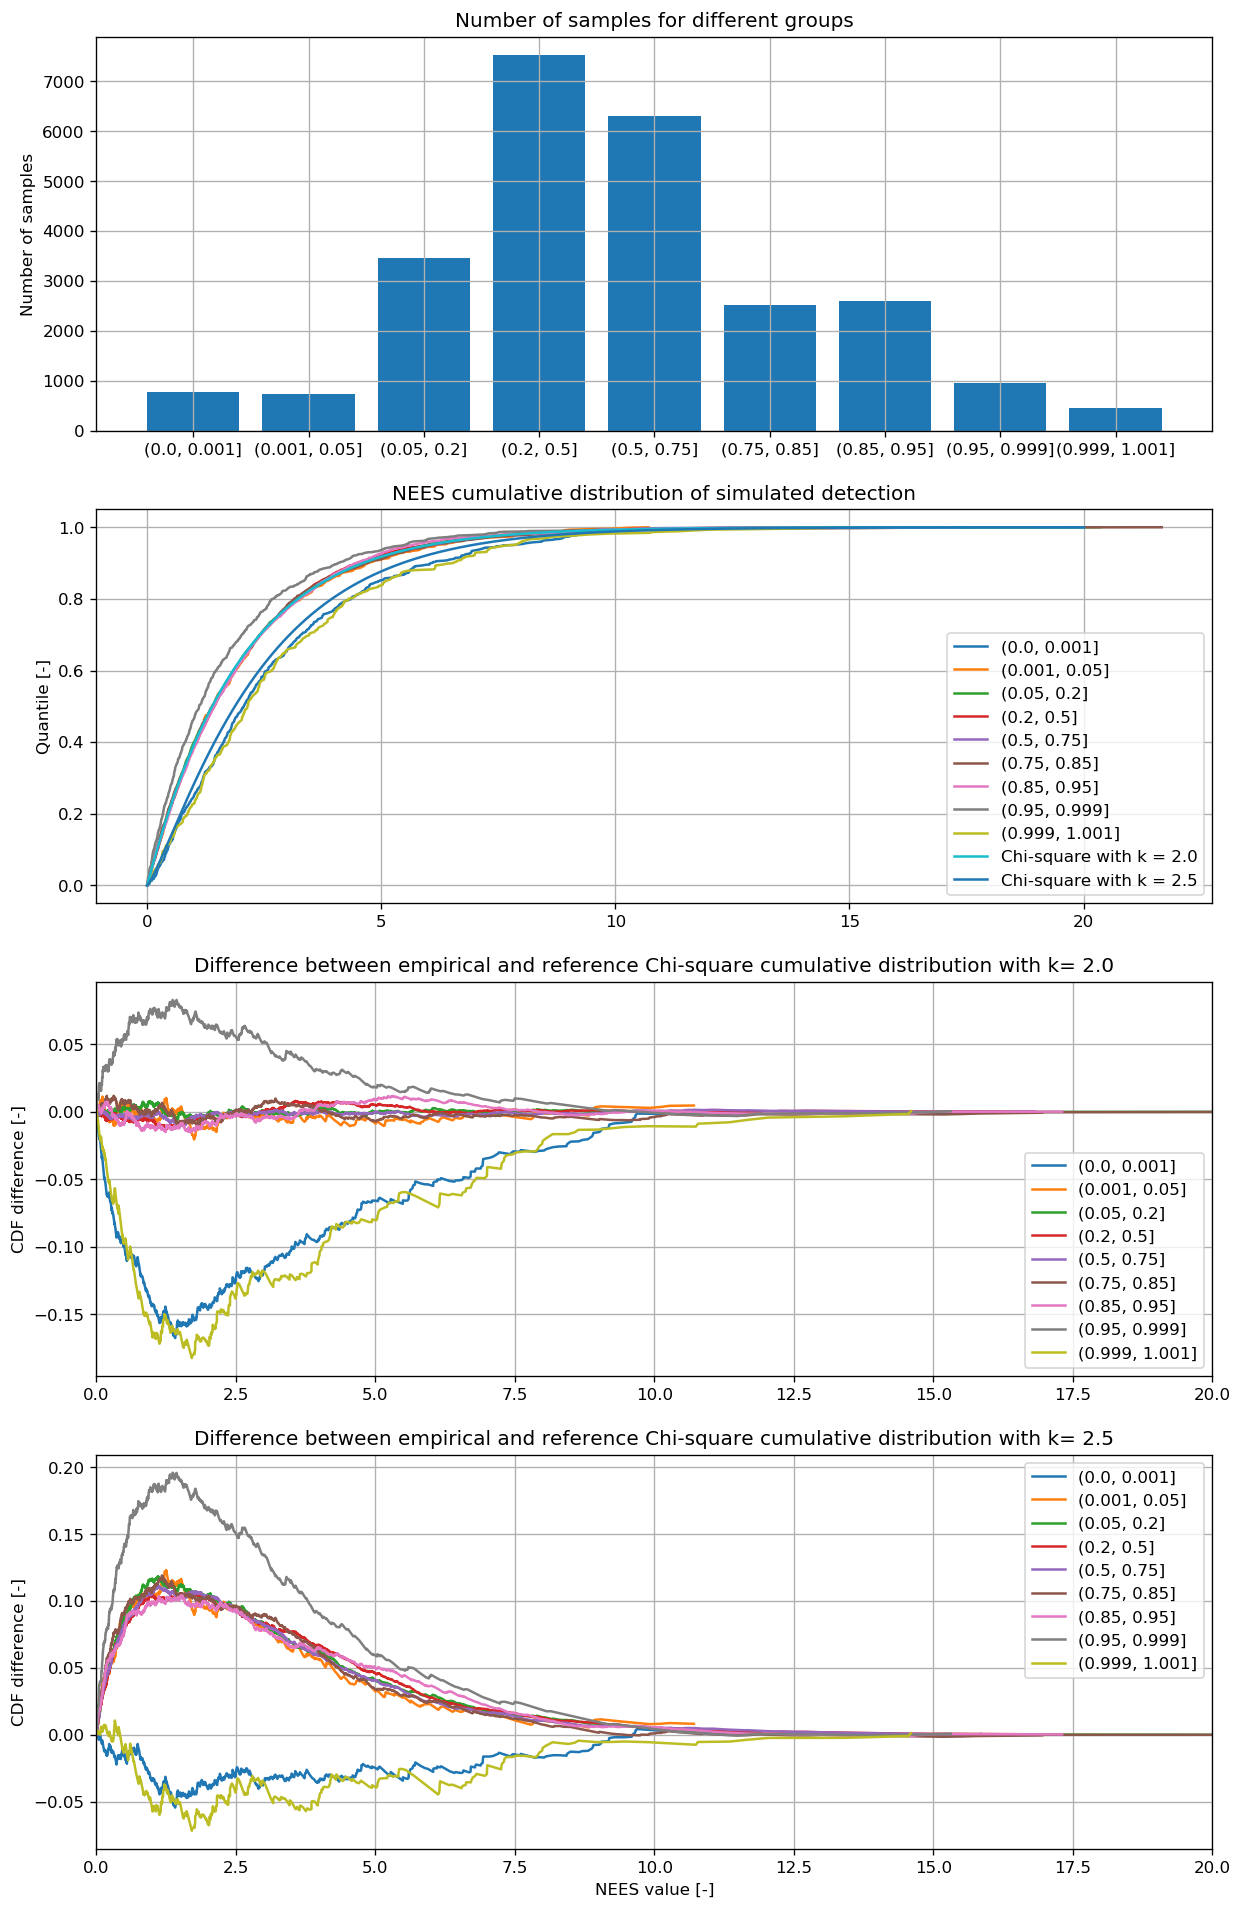

In [73]:
cut_off_points = [0, 1.0e-3, 0.05, 0.2, 0.5, 0.75, 0.85, 0.95, 0.999, 1.001]
cuted_data_est = sim_out.groupby(pd.cut(sim_out.vertex_id, cut_off_points))

fig3=plt.figure(figsize=(12, 20), dpi= 120, facecolor='w', edgecolor='k')
visualize_distributions(cuted_data_est)

## For Grount Truth data

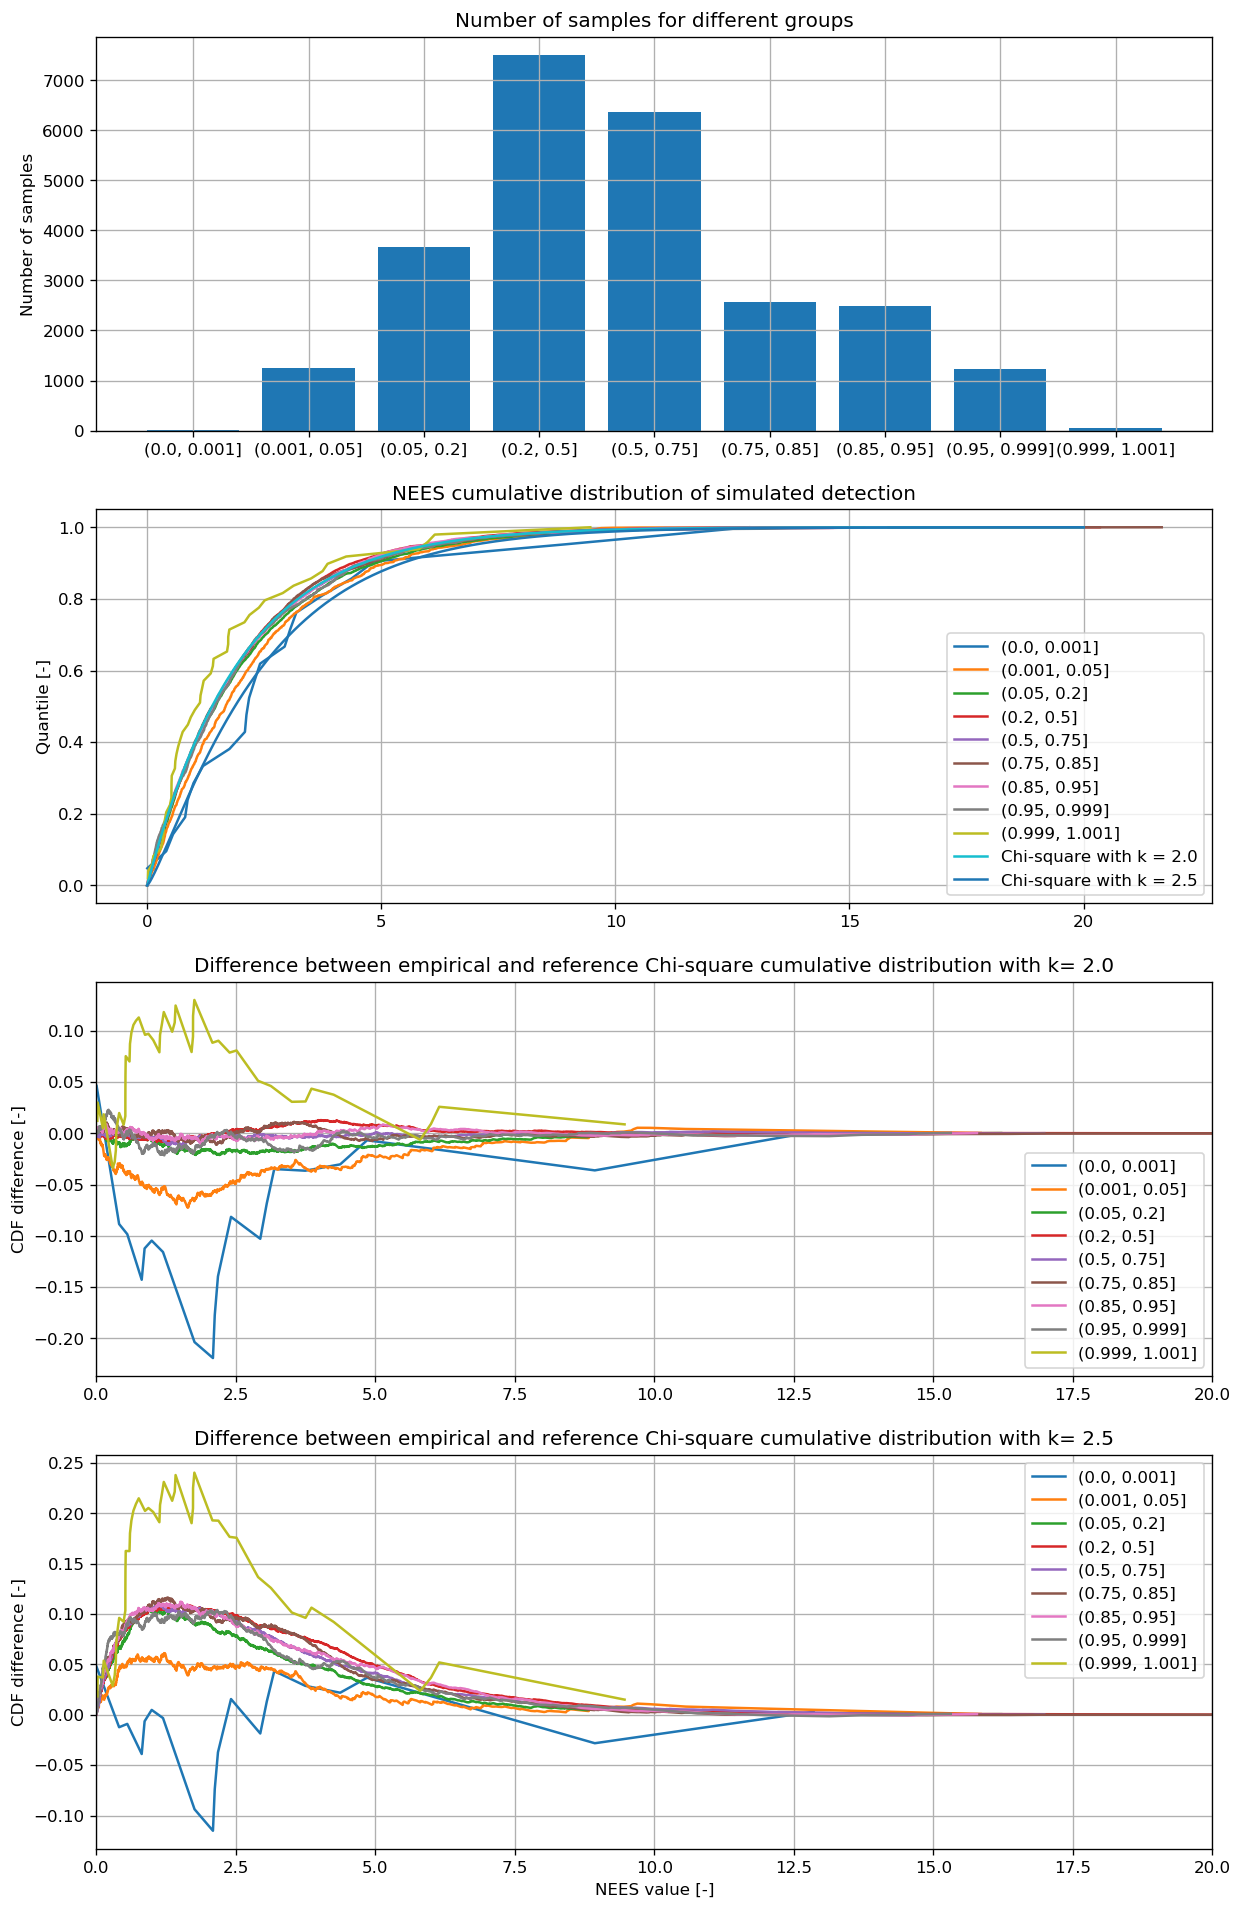

In [74]:
cut_off_points = [0, 1.0e-3, 0.05, 0.2, 0.5, 0.75, 0.85, 0.95, 0.999, 1.001]
cuted_data_gt = sim_out.groupby(pd.cut(sim_out.gt_vertex_id, cut_off_points))

fig3=plt.figure(figsize=(12, 20), dpi= 120, facecolor='w', edgecolor='k')
visualize_distributions(cuted_data_gt)